In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt

## here are the user-defined functions and classes
from MarkovComputations import *

In [21]:
### Define parameters of classification
M = 2 # how many edges affected per input dimension
n_classes = 2 # D, how many classes
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 10 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0


############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 

## get input and output inds
rand_bool = True
output_inds = get_output_inds(n_nodes, n_classes, rand_bool)
input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)


A_fac = -5
b_fac = 1

############################################################
################  Load classification data #################
############################################################

######  Gaussian example
n_samples = 20000

# ### one-dimensional example
mu_1 = 12
sigma_1 = 1.5
dist_1 = np.random.normal(mu_1, sigma_1, n_samples)

mu_2 = -12
sigma_2 = 1.5
dist_2 = np.random.normal(mu_2, sigma_2, n_samples)

mu_3 = 0
sigma_3 = 1.5
dist_3 = np.random.normal(mu_3, sigma_3, n_samples)

data_list = [[[dat] for dat in dist_1], [[dat] for dat in dist_2], [[dat] for dat in dist_3]]
n_classes = 3

# ## two-dimensional example
# mu_1 = -10 * np.ones(input_dim)
# cov_1 = 1.0 * np.diag(np.ones(input_dim))
# dist_1 = np.random.multivariate_normal(mu_1, cov_1, n_samples)

# mu_2 = 10 * np.ones(input_dim)
# cov_2 = 1.0 * np.diag(np.ones(input_dim))
# dist_2 = np.random.multivariate_normal(mu_2, cov_2, n_samples)

# data_list = [[dat for dat in dist_1], [dat for dat in dist_2]]


###  create InputData object
input_data = InputData(n_classes, data_list)


# L = 3
# external_input_dim = input_dim
# external_output_dim = n_classes

# internal_input_dims = [3, 3]
# internal_output_dims = [3, 3]
# M_vals = [M, M, M]

L = 1
external_input_dim = input_dim
external_output_dim = n_classes

internal_input_dims = []
internal_output_dims = []
M_vals = [M]

# L = 4
# external_input_dim = input_dim
# external_output_dim = n_classes

# internal_input_dims = [1, 2, 3]
# internal_output_dims = [4, 5, 6]
# M_vals = [M, M, M, M]

# L = 2
# external_input_dim = input_dim
# external_output_dim = n_classes

# internal_input_dims = [8]
# internal_output_dims = [5]
# M_vals = [M, M]

# A_fac = 20
# b_fac = 0


external_input_inds = get_input_inds(n_edges, input_dim, M)

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]
stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)





In [ ]:
################################################
################  Run training #################
################################################

stacked_weight_matrix_orig = copy.deepcopy(stacked_weight_matrices)  # save original rate matrix 

error_list = []  # track errors during training
accuracy_list = []
accuracy_stride = 10

n_training_iters = 100  # how many training steps to take
batch_size = 5         # set your batch size
eta_markov = 5e-2

adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8

for training_iter in range(n_training_iters):

    stacked_weight_matrices.zero_gradients()  # Zero the accumulators at the start of each batch

    for _ in range(batch_size):
        class_number = random.randrange(n_classes)  # draw a random class label to present

        inputs = input_data.get_next_training_sample(class_number)

        # Compute gradients for this sample
        markov_grads = stacked_weight_matrices.compute_gradients_single(inputs, class_number)
        # Accumulate gradients
        stacked_weight_matrices.accumulate_gradients(markov_grads)

        # Optionally, you can compute and store the error for this sample
        ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs(inputs)
        error_list.append(
            np.linalg.norm(
                compute_error(ss_list[-1], input_data, class_number, stacked_weight_matrices.external_output_inds)
            )
        )

    #print(stacked_weight_matrices.markov_grad_accum['theta'][0])
    # After accumulating over the batch, apply the Adam optimizer update
    stacked_weight_matrices.apply_adam_gradients(
        batch_size, eta_markov, adam_beta1, adam_beta2, adam_epsilon
    )

     # Compute accuracy using the perceptron-based network
    if (training_iter % accuracy_stride == 0):
        print(training_iter)
        accuracy_list.append(
            evaluate_accuracy(stacked_weight_matrices, input_data, n_classes, 10)
        )
    

   
    

0
10
20
30
40
50
60
70
80
90


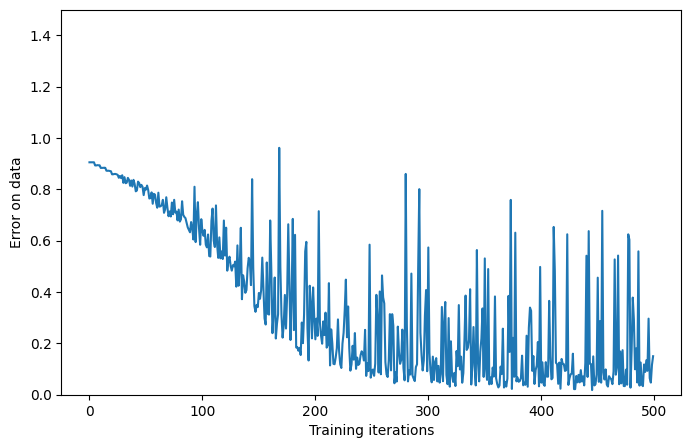

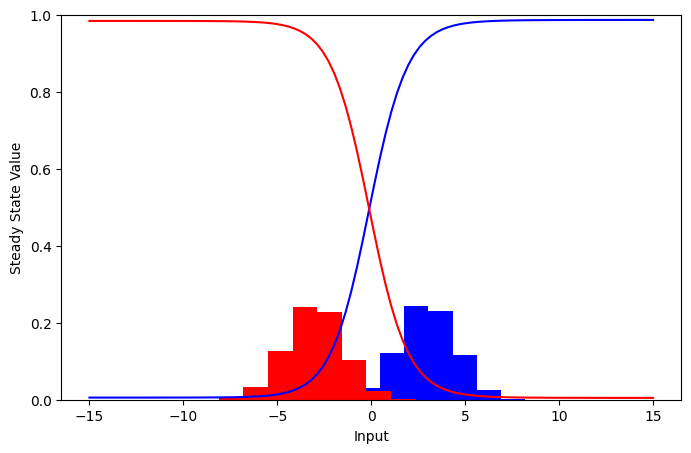

In [4]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
#plt.xlim(0,n_training_iters)
plt.show()


# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = np.zeros((len(x_values), len(output_inds)))


out_ind = 1
for (i, x) in enumerate(x_values):
    
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_at_outputs = [ss_list[-1][out] for out in stacked_weight_matrices.external_output_inds]
    ss_values[i,:] = ss_at_outputs  # Assuming node index 1 is of interest


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values[:,0], label="Steady State at Node 1", color='b')
plt.plot(x_values, ss_values[:,1], label="Steady State at Node 2", color='r')

plt.hist(dist_1, density=True, color='b')
plt.hist(dist_2, density=True, color='r')

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.ylim(0,1.)
#plt.legend()
plt.show()



In [28]:

E_range = 1
B_range = 1
F_range = 1


## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]
stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)



mi_list = train_mi_conjugate_gradient(
    stacked_weight_matrices,
    input_data,
    n_nodes,
    n_classes,
    n_samples=100,
    n_epochs=20,
    step_size=1e1,
    tol=1e-6,
    verbose=False
)

Training complete.


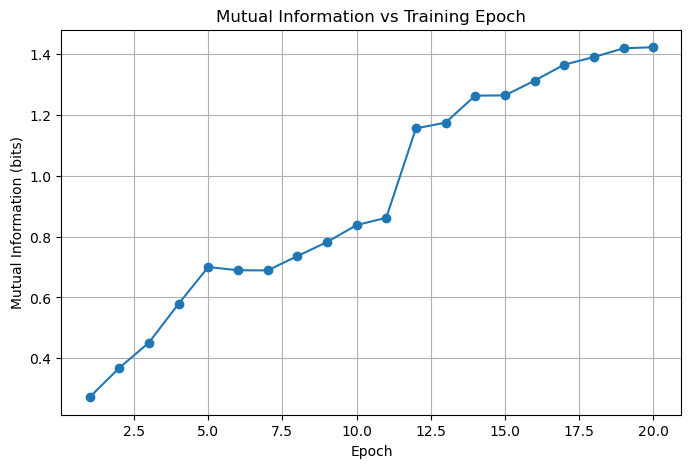

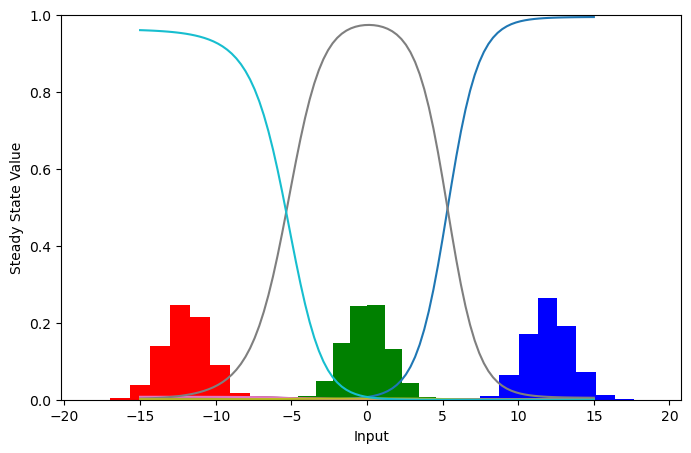

In [29]:
# Plot the mutual information over training epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mi_list) + 1), mi_list, '-o')
plt.xlabel('Epoch')
plt.ylabel('Mutual Information (bits)')
plt.title('Mutual Information vs Training Epoch')
plt.grid(True)
plt.show()


# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = np.zeros((len(x_values), n_nodes))


out_ind = 1
for (i, x) in enumerate(x_values):
    
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_values[i,:] = ss_list[-1]  # Assuming node index 1 is of interest


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values[:,:], label="Steady State at Node 1")
#plt.plot(x_values, ss_values[:,1], label="Steady State at Node 2", color='r')

plt.hist(dist_1, density=True, color='b')
plt.hist(dist_2, density=True, color='r')
plt.hist(dist_3, density=True, color='g')

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.ylim(0,1.)
#plt.legend()
plt.show()